In [706]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
import pickle, random
from tqdm import tqdm
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

In [707]:
#!pip install matplotlib

In [708]:
#df0 = pd.read_csv('../spreadsheets/rlhf_20250104_6.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_159nlp.csv') # Best
#df0 = pd.read_csv('../spreadsheets/rlhf_1064_2.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_1072.csv') # 0.05, 0.95, 1.0, 0.999, 0.995, 12000
#df0 = pd.read_csv('../spreadsheets/shufled_rlhf_11rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_12rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_15rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_19rl.csv') # 0.005, 0.75, 0.1, 0.95, 0.999, 12000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_23rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_24rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_25rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_26rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_157nlp.csv') # 0.7, 0.95, 0.5, 0.999, 0.99, 16000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_29rl.csv') # 0.9, 0.9, 0.005, 0.95, 0.999, 10000, 0.9, 0.95, 1.0, 0.99, 0.99, 8000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_30rl.csv') # 
#df0 = pd.read_csv('../spreadsheets/rlhf_large_32rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_33rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_35rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_37rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_27rl2.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_38rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_42rl.csv') # 0.01, 0.99, 1.0, 0.95, 0.99, 16000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_154nlp.csv') # 0.9, 0.9, 0.005, 0.95, 0.999, 10000
#df0 = pd.read_csv('../spreadsheets/rlhf_bid_47rl_refined.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_50rl.csv')
df0 = pd.read_csv('../spreadsheets/rlhf_large_154nlp_refined.csv')

In [709]:
df0.columns

Index(['ask', 'bid', 'sma-compare', 'is_short', 'action', 'predicted_action',
       'reward', 'refined-action'],
      dtype='object')

In [710]:
#df0['ask'] = df0['close'] * df0['volume']/(df0['close'] + df0['open'])

In [711]:
#df0['bid'] = df0['open'] * df0['volume']/(df0['close'] + df0['open'])

In [712]:
df0.columns

Index(['ask', 'bid', 'sma-compare', 'is_short', 'action', 'predicted_action',
       'reward', 'refined-action'],
      dtype='object')

In [713]:
df0.head()

,ask,bid,sma-compare,is_short,action,predicted_action,reward,refined-action
0,2.018487e+04,2.024511e+04,0,0,go_long,go_long,12.655161,go_long
1,1.410609e+06,1.440998e+06,1,0,go_long,go_long,38.210539,go_long
2,4.924476e+06,5.027070e+06,1,1,go_short,go_long,-5.774026,go_long
3,6.770843e+05,6.686044e+05,0,1,go_short,do_nothing,-2.632130,do_nothing
4,2.693704e+03,2.677647e+03,0,0,go_long,go_long,38.482866,go_long


In [714]:
#df0.drop(['Unnamed: 0'], axis=1, inplace=True)

In [715]:
df0['action'].value_counts()

action
go_short    651
go_long     440
Name: count, dtype: int64

In [716]:
#action_mapping = {"go_long": 0, "go_short": 1}

In [717]:
def prep_data(df: DataFrame) -> DataFrame:
    train_data = pd.DataFrame()
    for col in df.columns:
        col_name = col.split(' ')[0]
        train_data[f'{col_name}'] = df[col]

    return train_data

In [718]:
newdf0 = pd.DataFrame()
train_data = df0 if newdf0.empty else newdf0

In [719]:
train_data.head(2)

,ask,bid,sma-compare,is_short,action,predicted_action,reward,refined-action
0,2.018487e+04,2.024511e+04,0,0,go_long,go_long,12.655161,go_long
1,1.410609e+06,1.440998e+06,1,0,go_long,go_long,38.210539,go_long


In [720]:
new_cols = ['ask','bid','sma-compare','is_short']

In [ ]:
# Encode actions into numerical values
action_mapping = {"go_long": 0, "go_short": 1, "do_nothing": 2}
action_col = 'nlpreds' if newdf0.empty else 'refined-action'
train_data["action_num"] = train_data[f"{action_col}"].map(action_mapping)

In [722]:
train_data.columns

Index(['ask', 'bid', 'sma-compare', 'is_short', 'action', 'predicted_action',
       'reward', 'refined-action', 'action_num'],
      dtype='object')

In [723]:
# Define RL parameters
#states = train_data[["sma-05", "sma-07", "sma-25", "sma-compare", "is_short"]].values  # Include binary_state
states = train_data[new_cols].values

actions = list(action_mapping.values())  # Action space
rewards = train_data["reward"].values  # Rewards
n_states = states.shape[0]
n_actions = len(actions)


In [724]:
# Initialize Q-table
q_table = np.zeros((n_states, n_actions))

In [725]:
Hyperparameters = [
    [0.1, 0.9, 0.1, 0.99, 0.995, 4000],
    [0.005, 0.75, 0.1, 0.95, 0.999, 12000],
    [0.001, 0.75, 1.0, 0.99, 0.99, 30000],
    [1, 0.75, 0.005, 0.95, 0.95, 22000],
    [0.01, 0.99, 1.0, 0.95, 0.99, 16000],
    [0.7, 0.99, 1.0, 0.95, 0.997, 8000],
    [0.01, 0.95, 1.0, 0.997, 0.995, 26000],
    [0.25, 0.95, 0.01, 0.997, 0.999, 14000],
    [0.5, 0.85, 0.5, 0.997, 0.997, 14000],
    [0.01, 0.85, 0.01, 0.95, 0.95, 12000],
    [0.9, 0.99, 0.5, 0.995, 0.95, 12000],
    [0.05, 0.9, 0.5, 0.95, 0.999, 4000],
    [0.05, 0.99, 0.5, 0.99, 0.997, 6000],
    [1, 0.75, 0.05, 0.999, 0.999, 10000],
    [0.9, 0.95, 1.0, 0.99, 0.99, 8000],
    [0.25, 0.75, 0.01, 0.995, 0.999, 20000],
    [0.3, 0.75, 1.0, 0.995, 0.99, 10000],
    [1, 0.9, 1.0, 0.999, 0.999, 10000],
    [0.7, 0.75, 1.0, 0.97, 0.999, 28000],
    [0.05, 0.95, 1.0, 0.999, 0.995, 12000],
    [0.7, 0.95, 0.5, 0.999, 0.99, 16000],
    [0.25, 0.95, 1.0, 0.99, 0.99, 10000],
    [0.25, 0.99, 0.01, 0.997, 0.99, 8000],
    [1, 0.95, 0.1, 0.96, 0.96, 12000],
    [0.9, 0.9, 0.005, 0.95, 0.999, 10000],
    [1, 0.9, 1.0, 0.99, 0.99, 11000],
    [0.5, 0.75, 0.005, 0.95, 0.999, 14000],
    [0.7, 0.9, 0.05, 0.95, 0.95, 20000]

]

In [726]:
for i in enumerate(Hyperparameters):
    print(i)

(0, [0.1, 0.9, 0.1, 0.99, 0.995, 4000])
(1, [0.005, 0.75, 0.1, 0.95, 0.999, 12000])
(2, [0.001, 0.75, 1.0, 0.99, 0.99, 30000])
(3, [1, 0.75, 0.005, 0.95, 0.95, 22000])
(4, [0.01, 0.99, 1.0, 0.95, 0.99, 16000])
(5, [0.7, 0.99, 1.0, 0.95, 0.997, 8000])
(6, [0.01, 0.95, 1.0, 0.997, 0.995, 26000])
(7, [0.25, 0.95, 0.01, 0.997, 0.999, 14000])
(8, [0.5, 0.85, 0.5, 0.997, 0.997, 14000])
(9, [0.01, 0.85, 0.01, 0.95, 0.95, 12000])
(10, [0.9, 0.99, 0.5, 0.995, 0.95, 12000])
(11, [0.05, 0.9, 0.5, 0.95, 0.999, 4000])
(12, [0.05, 0.99, 0.5, 0.99, 0.997, 6000])
(13, [1, 0.75, 0.05, 0.999, 0.999, 10000])
(14, [0.9, 0.95, 1.0, 0.99, 0.99, 8000])
(15, [0.25, 0.75, 0.01, 0.995, 0.999, 20000])
(16, [0.3, 0.75, 1.0, 0.995, 0.99, 10000])
(17, [1, 0.9, 1.0, 0.999, 0.999, 10000])
(18, [0.7, 0.75, 1.0, 0.97, 0.999, 28000])
(19, [0.05, 0.95, 1.0, 0.999, 0.995, 12000])
(20, [0.7, 0.95, 0.5, 0.999, 0.99, 16000])
(21, [0.25, 0.95, 1.0, 0.99, 0.99, 10000])
(22, [0.25, 0.99, 0.01, 0.997, 0.99, 8000])
(23, [1, 0.95,

In [727]:
#print(*Hyperparameters[0])
'''
alpha = 1
gamma = 0.95
epsilon = 0.1
min_epsilon = 0.96
decay_rate = 0.96
n_episodes = 12000
'''

alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes = Hyperparameters[27] #Hyperparameters[26] #Hyperparameters[24] # Hyperparameters[9] # Hyperparameters[22] #Hyperparameters[6]



In [728]:
def create_state_index_mapping(df):
    state_to_index = {}
    for idx, row in df.iterrows():
        state = (row['ask'], row['bid'], row['sma-compare'], row['is_short'])
        state_to_index[state] = idx
    return state_to_index

# Assuming 'df' is your dataframe used during training
state_to_index = create_state_index_mapping(train_data)

# Save the state_to_index dictionary for later use
np.save('bids_state_to_index.npy', state_to_index)


In [729]:
# Helper function to choose an action using epsilon-greedy
def choose_action(state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.randint(0, n_actions)  # Explore: random action
    else:
        return np.argmax(q_table[state])  # Exploit: best known action

evaluating results per episode ...:   0%|          | 33/20000 [00:00<01:00, 329.34it/s]

Episode 0/20000 - Total Reward: 340.60188608000016, Epsilon: 0.95


evaluating results per episode ...:   2%|▏         | 450/20000 [00:01<01:05, 297.19it/s]

Episode 400/20000 - Total Reward: 452.6104830400002, Epsilon: 0.95


evaluating results per episode ...:   4%|▍         | 836/20000 [00:02<01:00, 318.92it/s]

Episode 800/20000 - Total Reward: 276.0700809799999, Epsilon: 0.95


evaluating results per episode ...:   6%|▋         | 1262/20000 [00:04<01:00, 308.30it/s]

Episode 1200/20000 - Total Reward: 359.0208115000002, Epsilon: 0.95


evaluating results per episode ...:   8%|▊         | 1639/20000 [00:05<00:59, 311.11it/s]

Episode 1600/20000 - Total Reward: -4.65846437, Epsilon: 0.95


evaluating results per episode ...:  10%|█         | 2036/20000 [00:06<01:02, 289.33it/s]

Episode 2000/20000 - Total Reward: 291.2534805799999, Epsilon: 0.95


evaluating results per episode ...:  12%|█▏        | 2469/20000 [00:08<00:53, 328.22it/s]

Episode 2400/20000 - Total Reward: 302.50666160000003, Epsilon: 0.95


evaluating results per episode ...:  14%|█▍        | 2864/20000 [00:09<00:55, 309.42it/s]

Episode 2800/20000 - Total Reward: 1343.4230749300034, Epsilon: 0.95


evaluating results per episode ...:  16%|█▌        | 3230/20000 [00:10<00:57, 289.22it/s]

Episode 3200/20000 - Total Reward: 633.6167272599998, Epsilon: 0.95


evaluating results per episode ...:  18%|█▊        | 3661/20000 [00:12<00:55, 296.89it/s]

Episode 3600/20000 - Total Reward: 251.37461664000017, Epsilon: 0.95


evaluating results per episode ...:  20%|██        | 4058/20000 [00:13<00:50, 316.34it/s]

Episode 4000/20000 - Total Reward: 198.36499062000004, Epsilon: 0.95


evaluating results per episode ...:  22%|██▏       | 4442/20000 [00:14<00:52, 294.80it/s]

Episode 4400/20000 - Total Reward: 428.70894194000016, Epsilon: 0.95


evaluating results per episode ...:  24%|██▍       | 4842/20000 [00:16<00:52, 289.90it/s]

Episode 4800/20000 - Total Reward: 202.7039195300001, Epsilon: 0.95


evaluating results per episode ...:  26%|██▋       | 5257/20000 [00:17<00:47, 310.70it/s]

Episode 5200/20000 - Total Reward: 714.6141577899998, Epsilon: 0.95


evaluating results per episode ...:  28%|██▊       | 5643/20000 [00:18<00:46, 308.98it/s]

Episode 5600/20000 - Total Reward: 256.9449448000001, Epsilon: 0.95


evaluating results per episode ...:  30%|███       | 6042/20000 [00:20<00:47, 295.96it/s]

Episode 6000/20000 - Total Reward: 721.2358321499992, Epsilon: 0.95


evaluating results per episode ...:  32%|███▏      | 6430/20000 [00:21<00:44, 304.29it/s]

Episode 6400/20000 - Total Reward: 568.9325845899996, Epsilon: 0.95


evaluating results per episode ...:  34%|███▍      | 6858/20000 [00:22<00:43, 304.66it/s]

Episode 6800/20000 - Total Reward: 309.1928645500001, Epsilon: 0.95


evaluating results per episode ...:  36%|███▋      | 7266/20000 [00:24<00:41, 306.64it/s]

Episode 7200/20000 - Total Reward: 8.01702796, Epsilon: 0.95


evaluating results per episode ...:  38%|███▊      | 7644/20000 [00:25<00:40, 307.87it/s]

Episode 7600/20000 - Total Reward: 1205.5803092100007, Epsilon: 0.95


evaluating results per episode ...:  40%|████      | 8030/20000 [00:26<00:40, 294.35it/s]

Episode 8000/20000 - Total Reward: 219.0864990700001, Epsilon: 0.95


evaluating results per episode ...:  42%|████▏     | 8456/20000 [00:28<00:38, 301.18it/s]

Episode 8400/20000 - Total Reward: 265.8658925699999, Epsilon: 0.95


evaluating results per episode ...:  44%|████▍     | 8856/20000 [00:29<00:35, 315.03it/s]

Episode 8800/20000 - Total Reward: 352.6251306400002, Epsilon: 0.95


evaluating results per episode ...:  46%|████▋     | 9250/20000 [00:31<00:41, 261.41it/s]

Episode 9200/20000 - Total Reward: 553.5827852799994, Epsilon: 0.95


evaluating results per episode ...:  48%|████▊     | 9654/20000 [00:32<00:35, 292.78it/s]

Episode 9600/20000 - Total Reward: 624.6250820499997, Epsilon: 0.95


evaluating results per episode ...:  50%|█████     | 10063/20000 [00:33<00:33, 294.91it/s]

Episode 10000/20000 - Total Reward: 396.1933804700002, Epsilon: 0.95


evaluating results per episode ...:  52%|█████▏    | 10467/20000 [00:35<00:26, 353.77it/s]

Episode 10400/20000 - Total Reward: 224.66267308000002, Epsilon: 0.95


evaluating results per episode ...:  54%|█████▍    | 10859/20000 [00:36<00:27, 333.93it/s]

Episode 10800/20000 - Total Reward: 377.0969163900003, Epsilon: 0.95


evaluating results per episode ...:  56%|█████▌    | 11249/20000 [00:37<00:29, 300.07it/s]

Episode 11200/20000 - Total Reward: 494.45520639999967, Epsilon: 0.95


evaluating results per episode ...:  58%|█████▊    | 11645/20000 [00:38<00:26, 312.98it/s]

Episode 11600/20000 - Total Reward: 485.83690853999985, Epsilon: 0.95


evaluating results per episode ...:  60%|██████    | 12033/20000 [00:40<00:24, 320.81it/s]

Episode 12000/20000 - Total Reward: 219.59422434000007, Epsilon: 0.95


evaluating results per episode ...:  62%|██████▏   | 12431/20000 [00:41<00:27, 272.60it/s]

Episode 12400/20000 - Total Reward: 248.19487238000013, Epsilon: 0.95


evaluating results per episode ...:  64%|██████▍   | 12837/20000 [00:42<00:22, 313.70it/s]

Episode 12800/20000 - Total Reward: 633.6225667399999, Epsilon: 0.95


evaluating results per episode ...:  66%|██████▌   | 13237/20000 [00:44<00:22, 302.17it/s]

Episode 13200/20000 - Total Reward: 278.0008185699999, Epsilon: 0.95


evaluating results per episode ...:  68%|██████▊   | 13658/20000 [00:45<00:19, 321.04it/s]

Episode 13600/20000 - Total Reward: 248.11220602000012, Epsilon: 0.95


evaluating results per episode ...:  70%|███████   | 14046/20000 [00:46<00:20, 293.14it/s]

Episode 14000/20000 - Total Reward: 258.31157528000006, Epsilon: 0.95


evaluating results per episode ...:  72%|███████▏  | 14454/20000 [00:48<00:19, 278.15it/s]

Episode 14400/20000 - Total Reward: 1068.55234224, Epsilon: 0.95


evaluating results per episode ...:  74%|███████▍  | 14844/20000 [00:49<00:18, 275.13it/s]

Episode 14800/20000 - Total Reward: 258.20195199000005, Epsilon: 0.95


evaluating results per episode ...:  76%|███████▌  | 15249/20000 [00:50<00:14, 319.56it/s]

Episode 15200/20000 - Total Reward: 8.682925540001795, Epsilon: 0.95


evaluating results per episode ...:  78%|███████▊  | 15642/20000 [00:52<00:13, 316.32it/s]

Episode 15600/20000 - Total Reward: 370.2182449500002, Epsilon: 0.95


evaluating results per episode ...:  80%|████████  | 16032/20000 [00:53<00:12, 311.15it/s]

Episode 16000/20000 - Total Reward: 458.3282340700001, Epsilon: 0.95


evaluating results per episode ...:  82%|████████▏ | 16450/20000 [00:54<00:11, 301.40it/s]

Episode 16400/20000 - Total Reward: 294.30211126999984, Epsilon: 0.95


evaluating results per episode ...:  84%|████████▍ | 16841/20000 [00:56<00:11, 274.99it/s]

Episode 16800/20000 - Total Reward: 555.4798109499994, Epsilon: 0.95


evaluating results per episode ...:  86%|████████▌ | 17243/20000 [00:57<00:09, 285.96it/s]

Episode 17200/20000 - Total Reward: 509.41131103999936, Epsilon: 0.95


evaluating results per episode ...:  88%|████████▊ | 17647/20000 [00:59<00:07, 298.63it/s]

Episode 17600/20000 - Total Reward: 725.8134901599996, Epsilon: 0.95


evaluating results per episode ...:  90%|█████████ | 18052/20000 [01:00<00:06, 315.07it/s]

Episode 18000/20000 - Total Reward: 197.9078089500001, Epsilon: 0.95


evaluating results per episode ...:  92%|█████████▏| 18452/20000 [01:01<00:05, 296.17it/s]

Episode 18400/20000 - Total Reward: 580.7152747799995, Epsilon: 0.95


evaluating results per episode ...:  94%|█████████▍| 18837/20000 [01:02<00:03, 294.21it/s]

Episode 18800/20000 - Total Reward: 77.02689424, Epsilon: 0.95


evaluating results per episode ...:  96%|█████████▌| 19236/20000 [01:04<00:02, 308.24it/s]

Episode 19200/20000 - Total Reward: 618.4554493699997, Epsilon: 0.95


evaluating results per episode ...:  98%|█████████▊| 19650/20000 [01:05<00:01, 297.39it/s]

Episode 19600/20000 - Total Reward: 264.49842200999996, Epsilon: 0.95


evaluating results per episode ...: 100%|██████████| 20000/20000 [01:06<00:00, 298.85it/s]


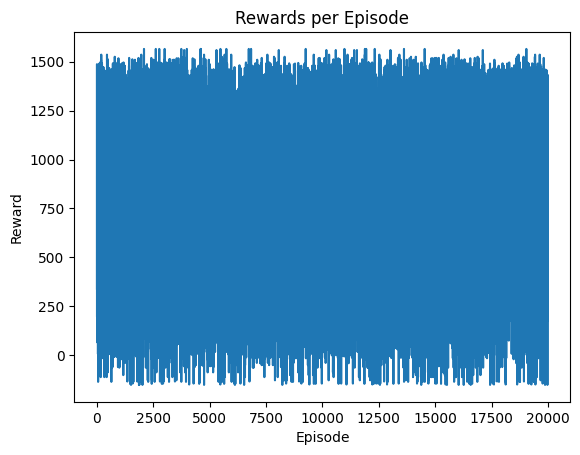

In [730]:

# Set random seed for reproducibility and train the loop
np.random.seed(42)
random.seed(42)
# Initialize a list to store rewards per episode
rewards_per_episode = []

for episode in tqdm(range(n_episodes), desc="evaluating results per episode ..."):
    current_state = np.random.randint(0, n_states)  # Random initial state
    total_reward = 0  # Initialize total reward for the current episode

    while current_state < n_states - 1:
        action = choose_action(current_state, epsilon)
        
        next_state = current_state + 1  # This depends on your environment logic
        reward = rewards[next_state]

        best_next_action = np.argmax(q_table[next_state])
        q_table[current_state, action] += alpha * (
            reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
        )
        
        total_reward += reward  # Accumulate reward for the current episode
        current_state = next_state  # Move to next state

    rewards_per_episode.append(total_reward)  # Store the total reward for the current episode

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * decay_rate)

    # Optional: Log progress
    if episode % 400 == 0:  # Adjust logging frequency as needed
        print(f"Episode {episode}/{n_episodes} - Total Reward: {total_reward}, Epsilon: {epsilon}")

# Example: Save the Q-table
np.save("bids_q_table.npy", q_table)

# Example: Plotting the rewards
import matplotlib.pyplot as plt

plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()



In [731]:
def load_q_table(file_path):
    return np.load(file_path)

def load_state_index_mapping(file_path):
    return np.load(file_path, allow_pickle=True).item()

loaded_state_to_index = load_state_index_mapping(file_path="bids_state_to_index.npy")
loaded_qtable = load_q_table(file_path="bids_q_table.npy")

In [732]:
#state = (row['open'], row['high'], row['ema-26'], row['ema-12'], row['low'], \
#                 row['mean-grad-hist'], row['close'], row['volume'], row['sma-25'], \
#                 row['long_jcrosk'], row['short_kdj'], row['sma-compare'], row['is_short'])

def prep_state(
                ask: float, bid: float, sma_compare: int, is_short: int
            ):
    state = np.array([[ask, bid, sma_compare, is_short]])
    if not np.all(np.isfinite(state)):
        state = np.nan_to_num(state, nan=0.0, posinf=0.0, neginf=0.0)
    return state


In [733]:

def predict_action(state, q_table, state_to_index, action_mapping, default_action: str = None):
    state_tuple = tuple(state.flatten())

    state_index = state_to_index.get(state_tuple, -1)
    #state_index = loaded_state_to_index.get(state_tuple, -1)
    if state_index != -1:
        try:
            q_values = q_table[state_index]
        except ValueError as e:
            print(e)
            #return default_action
    else:
        state_tuples = list(state_to_index.keys())
        kdtree = KDTree(state_tuples)
        distance, index = kdtree.query(state.flatten())
        nearest_state_tuple = state_tuples[index]
        q_values = loaded_qtable[state_to_index[nearest_state_tuple]]
    
    #q_values = q_table[state_index]
    return [action for action, index in action_mapping.items() if index == np.argmax(q_values)][0]

In [734]:
# Predict an entire range
def predict_range(df: DataFrame = train_data) -> DataFrame:
    for idx, row in df.iterrows():
        state = row[['ask','bid','sma-compare', 'is_short']].values
        #q_table = loaded_qtable
        #state_to_index = loaded_state_to_index
        #action_mapping = {"go_long": 0, "go_short": 1, "do_nothing": 2}
        action = predict_action(state, q_table, state_to_index, action_mapping)
        df.loc[idx, "predicted_action"] = action
    return df

In [735]:
train_data = predict_range(train_data)

In [736]:
train_data['predicted_action'].value_counts()

predicted_action
go_long       1072
do_nothing      10
go_short         9
Name: count, dtype: int64

In [737]:
m = train_data[(train_data['predicted_action'] == 'go_long') & (train_data['reward'] > 0)]
m['is_short'].value_counts()

is_short
1    282
0    194
Name: count, dtype: int64

In [738]:
longs = dict(m['is_short'].value_counts().items()).get(0)
print(longs)
shorts = dict(m['is_short'].value_counts().items()).get(1)
print(shorts)

194
282


In [739]:
# Performance measures
# Initialize cumulative rewards
cumulative_predicted_reward = 0
cumulative_actual_reward = 0
#n_states = states.shape[0]
#q_table = loaded_qtable
# Iterate through states to calculate rewards
for state_index in range(n_states - 1):
    # Predicted action from Q-table
    predicted_action = np.argmax(q_table[state_index])  # Best action for the current state
    # Actual action from the ground truth
    actual_action = train_data["action_num"].iloc[state_index]

    # Get reward for predicted action only if it matches the actual action
    if predicted_action == actual_action:
        predicted_reward = rewards[state_index + 1]  # Reward for the correct prediction
        cumulative_predicted_reward += predicted_reward

    # Get actual reward for the ground truth action
    actual_reward = rewards[state_index + 1]
    cumulative_actual_reward += actual_reward

    # Optional: Log progress
    if state_index % 100 == 0:  # Adjust logging frequency as needed
        print(f"Processed state {state_index}/{n_states - 1}")
        print(f"Current Predicted Reward: {cumulative_predicted_reward}")
        print(f"Current Actual Reward: {cumulative_actual_reward}")

# Print results
print(f"Cumulative Predicted Reward: {cumulative_predicted_reward}")
print(f"Cumulative Actual Reward: {cumulative_actual_reward}")

# Optionally calculate efficiency
efficiency = (
    ((cumulative_predicted_reward - cumulative_actual_reward) / abs(cumulative_actual_reward)) * 100
    if cumulative_actual_reward != 0
    else 0
)
print(f"Prediction Efficiency: {efficiency:.2f}%")



Processed state 0/1090
Current Predicted Reward: 38.21053879
Current Actual Reward: 38.21053879
Processed state 100/1090
Current Predicted Reward: -439.27394514999986
Current Actual Reward: -1439.5238085599997
Processed state 200/1090
Current Predicted Reward: 103.4118569199999
Current Actual Reward: -828.56395646
Processed state 300/1090
Current Predicted Reward: 366.3734381199997
Current Actual Reward: -603.1857184999999
Processed state 400/1090
Current Predicted Reward: 458.5040095999997
Current Actual Reward: -472.609580099999
Processed state 500/1090
Current Predicted Reward: 442.7396787899997
Current Actual Reward: -552.2256943499984
Processed state 600/1090
Current Predicted Reward: 903.1367213299997
Current Actual Reward: -184.6029190499986
Processed state 700/1090
Current Predicted Reward: 870.4755930099999
Current Actual Reward: -267.82184308999854
Processed state 800/1090
Current Predicted Reward: 1034.4343203799995
Current Actual Reward: -271.7322811499985
Processed state 9

In [740]:
# Accuracy
correct_predictions = 0
for state_index in range(n_states):
    predicted_action = np.argmax(q_table[state_index])  # Predicted action
    actual_action = train_data["action_num"].iloc[state_index]  # Actual action
    if predicted_action == actual_action:
        correct_predictions += 1

accuracy = correct_predictions / n_states
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 68.47%


In [741]:
# Confusion matrix
y_true = train_data["action_num"]  # Actual actions
y_pred = [np.argmax(q_table[state_index]) for state_index in range(n_states)]  # Predicted actions

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[745   5   8]
 [303   2   2]
 [ 24   2   0]]


In [742]:
def confusion_accuracy(conf_matrix, n_states):
    # True Positives (TP): Diagonal elements of the confusion matrix
    TP = conf_matrix[0][0] + conf_matrix[1][1] + conf_matrix[2][2]
    # **True Positives**: 16 (class 0), 0 (class 1), 0 (class 2)
    return TP*100/n_states

In [743]:
#con_acc = confusion_accuracy(cm, n_states=n_states)
#print(f"confusion accuracy: {con_acc:.2f}%")

In [744]:
df0['is_short'].value_counts()

is_short
1    651
0    440
Name: count, dtype: int64

In [745]:
def action_reward(action: str, is_short: int):
    m = train_data[(train_data['predicted_action'] == f'{action}') & (train_data['is_short'] == is_short)]
    counts = m['is_short'].value_counts()
    total_reward = m['reward'].cumsum()[-1:].values[0]
    wins = len(m[m['reward'] > 0])
    losses = len(m[m['reward'] <= 0])
    return {
        'counts': counts.get(is_short),
        'total reward': total_reward,
        'winrate': f'{wins * 100 / (losses + wins):.2f}%',
        'per trade profit': m[m['reward'] > 0]['reward'].sum() / wins,
        'per trade loss': m[m['reward'] <= 0]['reward'].sum() / losses
    }

In [763]:
action_reward('go_long', 1)

{'counts': 645,
 'total reward': -908.9617523600001,
 'winrate': '43.72%',
 'per trade profit': 12.269209184184398,
 'per trade loss': -12.035478628925619}

In [747]:

dirs = [0,1]
for action in action_mapping.keys():
    for is_short in dirs:
        try:
            print(f'{action} {is_short}: {action_reward(action, is_short)}')
        except IndexError as e:
            print(e)
            


go_long 0: {'counts': 427, 'total reward': 1107.2167298899997, 'winrate': '45.43%', 'per trade profit': 19.107499549896907, 'per trade loss': -11.157245419699569}
go_long 1: {'counts': 645, 'total reward': -908.9617523600001, 'winrate': '43.72%', 'per trade profit': 12.269209184184398, 'per trade loss': -12.035478628925619}
go_short 0: {'counts': 4, 'total reward': -68.96317765, 'winrate': '25.00%', 'per trade profit': 2.94356565, 'per trade loss': -23.968914433333335}
go_short 1: {'counts': 5, 'total reward': -74.61071022, 'winrate': '0.00%', 'per trade profit': nan, 'per trade loss': -14.922142044000001}
do_nothing 0: {'counts': 9, 'total reward': -18.466058350000004, 'winrate': '44.44%', 'per trade profit': 24.846516742499997, 'per trade loss': -23.570425064}
do_nothing 1: {'counts': 1, 'total reward': -5.45886994, 'winrate': '0.00%', 'per trade profit': nan, 'per trade loss': -5.45886994}


/tmp/ipykernel_3167762/3005952004.py:11: RuntimeWarning: invalid value encountered in scalar divide
  'per trade profit': m[m['reward'] > 0]['reward'].sum() / wins,


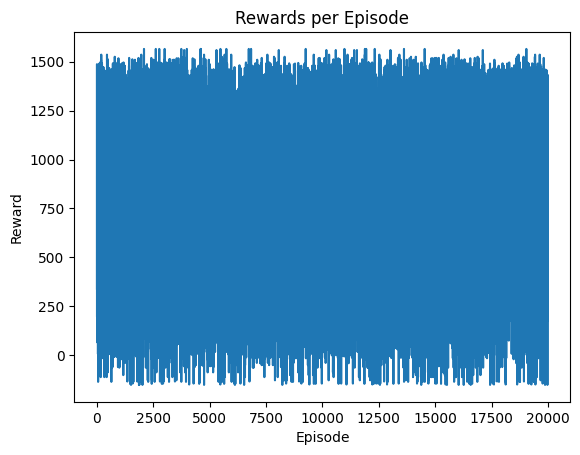

In [748]:
import matplotlib.pyplot as plt

# Assuming you have a list of rewards for each episode
#rewards_per_episode = [...]  # Populate this with your actual data

plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()


In [749]:
# create corrected action
def correct_action(row):
    if row['predicted_action'] == 'go_long' and row['is_short'] == 1 and row['reward'] > 0:
        return 'go_short'
    if row['predicted_action'] == 'go_short' and row['is_short'] == 0 and row['reward'] > 0:
        return 'go_long'
    if row['predicted_action'] == 'do_nothing' and row['is_short'] == 1 and row['reward'] > 0:
        return 'go_short'
    if row['predicted_action'] == 'do_nothing' and row['is_short'] == 0 and row['reward'] > 0:
        return 'go_long'
    return row['predicted_action']

def refiner_action(version: str, data: DataFrame = None) -> DataFrame:
    data['refined-action'] = data.apply(lambda x: correct_action(x), axis=1)
    # Validation: Ensure we're fixing the 751 misclassified entries
    misclassified = data[
        (data['predicted_action'] == 'go_long') & 
        (data['refined-action'] == 'go_short')
    ]
    # Add this after applying refined-action
    confusion_matrix = pd.crosstab(
        data['refined-action'], 
        data['predicted_action'],  # Assuming you have ground truth column
        rownames=['refined'],
        colnames=['predicted']
    )
    print("Updated Confusion Matrix:")
    print(confusion_matrix) 
    print(f"Corrected {len(misclassified)} go_long->go_short misclassifications")
    filename = f'../spreadsheets/rlhf_bid_{version}_refined.csv'
    data.to_csv(filename, index=False)
    return data

In [750]:
base_dir = '/home/defi/Desktop/portfolio/projects/python/pipeline_defi/'
#new_data = pd.read_csv('../spreadsheets/rlhf_small_154nlp.csv') 
def refine_file(version: str, file) -> DataFrame:
    filename = f'{base_dir}{file}.csv'
    print(filename)
    df = pd.read_csv(filename)
    #new_data = prep_data(df0.copy()) if newdf0.empty else prep_data(newdf0.copy())
    new_data = prep_data(df)   
    print(new_data.columns)
    new_train_data = refiner_action(version=version, data=new_data)

    #new_data = df0.copy()
    print(new_train_data.columns)

    new_train_data['nlpreds'] = new_train_data['predicted_action']
    #new_train_data['predicted_action'] = new_train_data['predicted_action']
    return new_train_data

In [751]:
newdf0 = refine_file('154nlp', 'lean_df_154nlp')

/home/defi/Desktop/portfolio/projects/python/pipeline_defi/lean_df_154nlp.csv
Index(['open', 'high', 'ema-26', 'ema-12', 'low', 'mean-grad-hist', 'close',
       'volume', 'sma-05', 'sma-07', 'sma-25', 'long_jcrosk', 'short_kdj',
       'sma-compare', 'ask', 'bid', 'is_short', 'nlpreds', 'predicted_action',
       'reward'],
      dtype='object')
Updated Confusion Matrix:
predicted   do_nothing  go_long  go_short
refined                                  
do_nothing         127        0         0
go_long             30      443        33
go_short            68      100       181
Corrected 100 go_long->go_short misclassifications
Index(['open', 'high', 'ema-26', 'ema-12', 'low', 'mean-grad-hist', 'close',
       'volume', 'sma-05', 'sma-07', 'sma-25', 'long_jcrosk', 'short_kdj',
       'sma-compare', 'ask', 'bid', 'is_short', 'nlpreds', 'predicted_action',
       'reward', 'refined-action'],
      dtype='object')


In [752]:
# Tuning
'''
def train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards):
    q_table = np.zeros((n_states, n_actions))
    rewards_per_episode = []

    for episode in range(n_episodes):
        current_state = np.random.randint(0, n_states)
        total_reward = 0

        while current_state < n_states - 1:
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.randint(0, n_actions)
            else:
                action = np.argmax(q_table[current_state])

            next_state = current_state + 1  # Adjust based on environment logic
            reward = rewards[next_state]

            best_next_action = np.argmax(q_table[next_state])
            q_table[current_state, action] += alpha * (
                reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
            )

            total_reward += reward
            current_state = next_state

        rewards_per_episode.append(total_reward)
        epsilon = max(min_epsilon, epsilon * decay_rate) # default min_epsilon = 0.01

    return q_table, rewards_per_episode
'''

'\ndef train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards):\n    q_table = np.zeros((n_states, n_actions))\n    rewards_per_episode = []\n\n    for episode in range(n_episodes):\n        current_state = np.random.randint(0, n_states)\n        total_reward = 0\n\n        while current_state < n_states - 1:\n            if np.random.uniform(0, 1) < epsilon:\n                action = np.random.randint(0, n_actions)\n            else:\n                action = np.argmax(q_table[current_state])\n\n            next_state = current_state + 1  # Adjust based on environment logic\n            reward = rewards[next_state]\n\n            best_next_action = np.argmax(q_table[next_state])\n            q_table[current_state, action] += alpha * (\n                reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]\n            )\n\n            total_reward += reward\n            current_state = next_state\n\n  

In [753]:

def evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards):
    correct_predictions = 0
    total_reward = 0
    reward_weighted_accuracy = []

    # Add tqdm for progress visualization
    for state_index in tqdm(range(n_states), desc="Evaluating States"):
        predicted_action = np.argmax(q_table[state_index])  # Predicted action
        actual_action = train_data["action_num"].iloc[state_index]  # Actual action
        reward = rewards[state_index]  # Reward for the action

        if predicted_action == actual_action:
            correct_predictions += 1
            total_reward += reward

        accuracy = correct_predictions / (state_index + 1)
        reward_weighted_accuracy.append(total_reward / (state_index + 1))

        # Optional: Log progress
        if state_index % 100 == 0:
            print(f"Processed state {state_index}/{n_states} - Accuracy: {accuracy * 100:.2f}%, Reward-weighted Accuracy: {reward_weighted_accuracy[-1]}")

    final_reward_weighted_accuracy = total_reward / n_states
    return final_reward_weighted_accuracy * 100



In [754]:
'''
def random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):
    best_params = None
    best_reward_weighted_accuracy = float('-inf')

    for _ in tqdm(range(n_iter), desc="Searching for params ..."):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        min_epsilon = random.choice(param_grid['decay_rate'])
        decay_rate = random.choice(param_grid['decay_rate'])
        n_episodes = random.choice(param_grid['n_episodes'])

        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)
        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)

        if reward_weighted_accuracy > best_reward_weighted_accuracy:
            best_reward_weighted_accuracy = reward_weighted_accuracy
            best_params = (alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes)

        print(f"Iteration Reward-weighted Accuracy: {reward_weighted_accuracy:.2f}%, Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")

    return best_params, best_reward_weighted_accuracy

# Define the parameter grid
param_grid = {
    'alpha': [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0.75, 0.85, 0.9, 0.95, 0.99],
    'epsilon': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005],
    'min_epsilon': [0.05, 0.01, 0.005, 0.001, 0.001],
    'decay_rate': [0.95, 0.99, 0.995, 0.997, 0.999],
    'n_episodes': [1500, 4000,6000, 8000, 9000, 10000, 11000, 12000]
}

# Perform Random Search
best_params, best_reward_weighted_accuracy = random_search_reward_weighted(50, param_grid, n_states, n_actions, rewards, train_data)
print(f"Best Hyperparameters: {best_params}")
print(f"Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")

'''

'\ndef random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):\n    best_params = None\n    best_reward_weighted_accuracy = float(\'-inf\')\n\n    for _ in tqdm(range(n_iter), desc="Searching for params ..."):\n        alpha = random.choice(param_grid[\'alpha\'])\n        gamma = random.choice(param_grid[\'gamma\'])\n        epsilon = random.choice(param_grid[\'epsilon\'])\n        min_epsilon = random.choice(param_grid[\'decay_rate\'])\n        decay_rate = random.choice(param_grid[\'decay_rate\'])\n        n_episodes = random.choice(param_grid[\'n_episodes\'])\n\n        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)\n        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)\n\n        if reward_weighted_accuracy > best_reward_weighted_accuracy:\n            best_reward_weighted_accuracy = reward_weighted_accuracy\n        

In [755]:
def evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards):
    # Initialize cumulative rewards
    cumulative_predicted_reward = 0
    cumulative_actual_reward = 0

    # Iterate through states to calculate rewards
    for state_index in range(n_states - 1):
        # Predicted action from Q-table
        predicted_action = np.argmax(q_table[state_index])  # Best action for the current state
        # Actual action from the ground truth
        actual_action = train_data["action_num"].iloc[state_index]

        # Get reward for predicted action only if it matches the actual action
        if predicted_action == actual_action:
            predicted_reward = rewards[state_index + 1]  # Reward for the correct prediction
            cumulative_predicted_reward += predicted_reward

        # Get actual reward for the ground truth action
        actual_reward = rewards[state_index + 1]
        cumulative_actual_reward += actual_reward
    return cumulative_predicted_reward

In [756]:
'''
train_data = newdf0
def random_search_prediction_efficiency(n_iter, param_grid, n_states, n_actions, rewards, train_data):
    best_params = None
    best_cumulative_pred_reward = float('-inf')

    for _ in tqdm(range(n_iter), desc="Searching for params ..."):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        min_epsilon = random.choice(param_grid['decay_rate'])
        decay_rate = random.choice(param_grid['decay_rate'])
        n_episodes = random.choice(param_grid['n_episodes'])

        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)
        cumulative_pred_reward = evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards)

        if cumulative_pred_reward > best_cumulative_pred_reward:
            best_cumulative_pred_reward = cumulative_pred_reward
            best_params = (alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes)

        print(f"Iteration cumulative predicted reward: {cumulative_pred_reward:.2f}%, Best cumulative predicted reward: {best_cumulative_pred_reward:.2f}%")

    return best_params, best_cumulative_pred_reward

# Define the parameter grid
param_grid = {
    'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0.75, 0.85, 0.9, 0.95, 0.99],
    'epsilon': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005],
    'min_epsilon': [0.05, 0.01, 0.005, 0.001, 0.001],
    'decay_rate': [0.95, 0.99, 0.995, 0.997, 0.999],
    'n_episodes': [1500, 4000,6000, 8000, 9000, 10000, 11000, 12000, 14000, 16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000]
}
# 1500, 4000,6000, 8000, 9000, 10000, 11000, 
# Perform Random Search
best_params, best_cumulative_pred_reward = random_search_prediction_efficiency(50, param_grid, n_states, n_actions, rewards, train_data)
print(f"Best Hyperparameters: {best_params}")
print(f"Best cumulative predicted reward: {best_cumulative_pred_reward:.2f}%")
'''

'\ntrain_data = newdf0\ndef random_search_prediction_efficiency(n_iter, param_grid, n_states, n_actions, rewards, train_data):\n    best_params = None\n    best_cumulative_pred_reward = float(\'-inf\')\n\n    for _ in tqdm(range(n_iter), desc="Searching for params ..."):\n        alpha = random.choice(param_grid[\'alpha\'])\n        gamma = random.choice(param_grid[\'gamma\'])\n        epsilon = random.choice(param_grid[\'epsilon\'])\n        min_epsilon = random.choice(param_grid[\'decay_rate\'])\n        decay_rate = random.choice(param_grid[\'decay_rate\'])\n        n_episodes = random.choice(param_grid[\'n_episodes\'])\n\n        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)\n        cumulative_pred_reward = evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards)\n\n        if cumulative_pred_reward > best_cumulative_pred_reward:\n            best_cumulative_pred_reward = cumulative_

In [757]:
colsa = ['ask','bid','sma-compare','is_short','predicted_action','reward']
learn_df = train_data[colsa]

In [758]:
def split_action(action: str):
    return ' '.join(action.split('_'))

In [759]:
#learn_df.loc[:,['predicted_action']] = learn_df['predicted_action'] #.apply(split_action)

In [760]:
learn_df.head()

,ask,bid,sma-compare,is_short,predicted_action,reward
0,2.018487e+04,2.024511e+04,0,0,go_long,12.655161
1,1.410609e+06,1.440998e+06,1,0,do_nothing,38.210539
2,4.924476e+06,5.027070e+06,1,1,go_short,-5.774026
3,6.770843e+05,6.686044e+05,0,1,go_long,-2.632130
4,2.693704e+03,2.677647e+03,0,0,go_long,38.482866


In [761]:
#learn_df.to_csv('/home/defi/Desktop/portfolio/projects/python/pipeline_defi/lean_df.csv', index=False)